In [594]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import scipy.ndimage
import scipy.optimize

In [9]:
from astropy.io import fits

In [13]:
analysis_root = '/Volumes/abraham/xcor_data/analysis/0372I/'
fname = '02a57639o0372I_original.fits'

hdulist = fits.open(analysis_root+fname)
img = 1.*hdulist[0].data
print(img.shape)
header = hdulist[0].header
hdulist.close()

(10560, 10560)


In [93]:
def median_bin_by_factor(img,factor):
    n_coarse = img.shape[0]/factor
    return np.median(np.median(img.reshape(n_coarse,factor,n_coarse,factor,),axis=1),axis=2)

def apply_amp_region_offsets(img,offsets):
    img_with_offsets = copy(img)
    n = img.shape[0]
    
    for regionx in range(2):
        for regiony in range(8):
            img_with_offsets[regionx*(n/2):(regionx+1)*(n/2),regiony*(n/8):(regiony+1)*(n/8)] += offsets[regionx][regiony]
    
    return img_with_offsets

def sub_median_from_each_amp_region(img):
    img2 = copy(img)
    n = img.shape[0]
    
    for regionx in range(2):
        for regiony in range(8):
            x1,x2 = regionx*(n/2),(regionx+1)*(n/2)
            y1,y2 = regiony*(n/8),(regiony+1)*(n/8)
            img2[x1:x2,y1:y2] -= np.median(img2[x1:x2,y1:y2])
    
    return img2

def draw_region_lines(n):
    sty = 'c:'
    for i in range(8):
        plt.plot([i*n/8,i*n/8],[0,n],sty)
        
    plt.plot([0,n],[n/2,n/2],sty)
    plt.xlim([0,n])
    plt.ylim([0,n])
            
# def mean_bin_by_factor(img,n_coarse,factor):
#     return img.reshape(n_coarse,factor,n_coarse,factor,).mean(1).mean(2)

# def mean_bin_by_factor_1D(img,n_coarse,factor):
#     return img.reshape(n_coarse,factor,).mean(1)

In [545]:
factor = 132/2
img_coarse = median_bin_by_factor(img,factor)
#img_coarser_resampled = scipy.ndimage.interpolation.zoom(median_bin_by_factor(img_coarse,4),zoom=4,order=0)
img_coarser = median_bin_by_factor(img,4*factor)
n_coarser = img_coarser.shape[0]

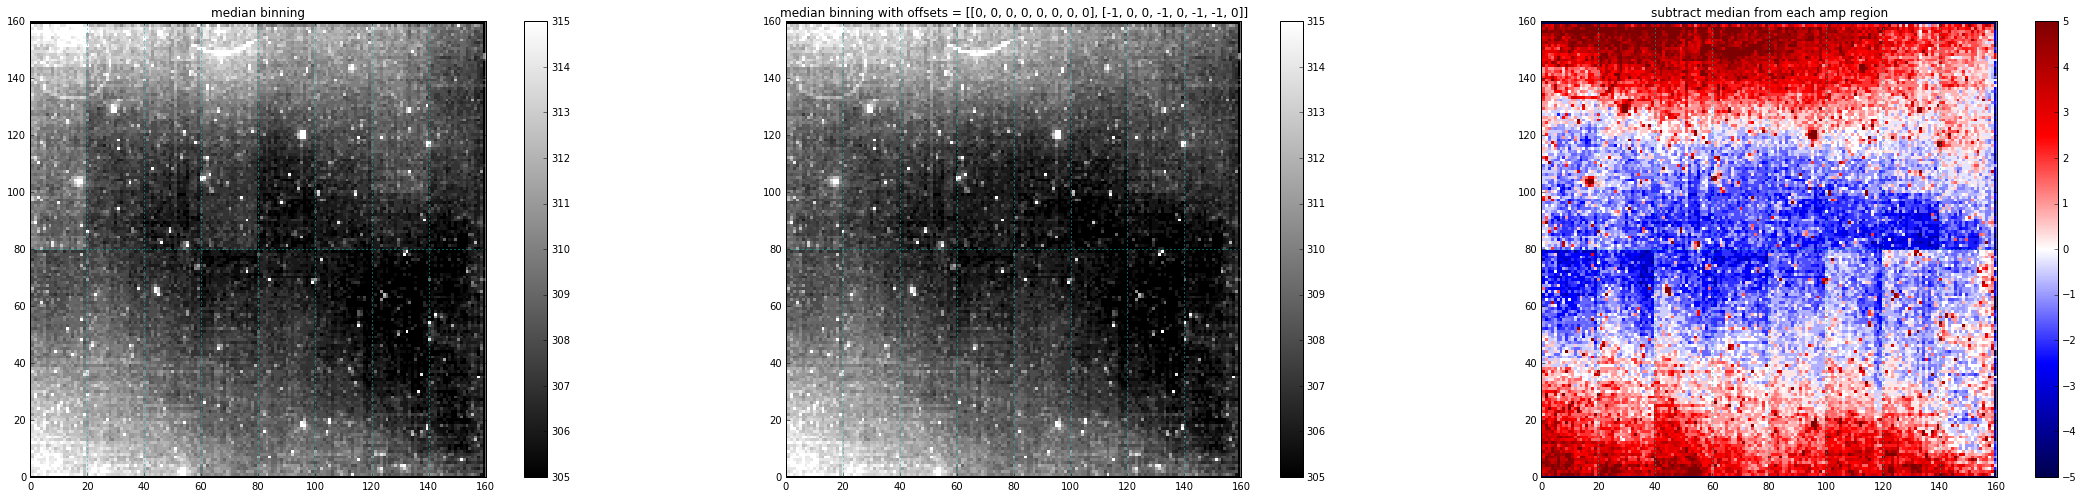

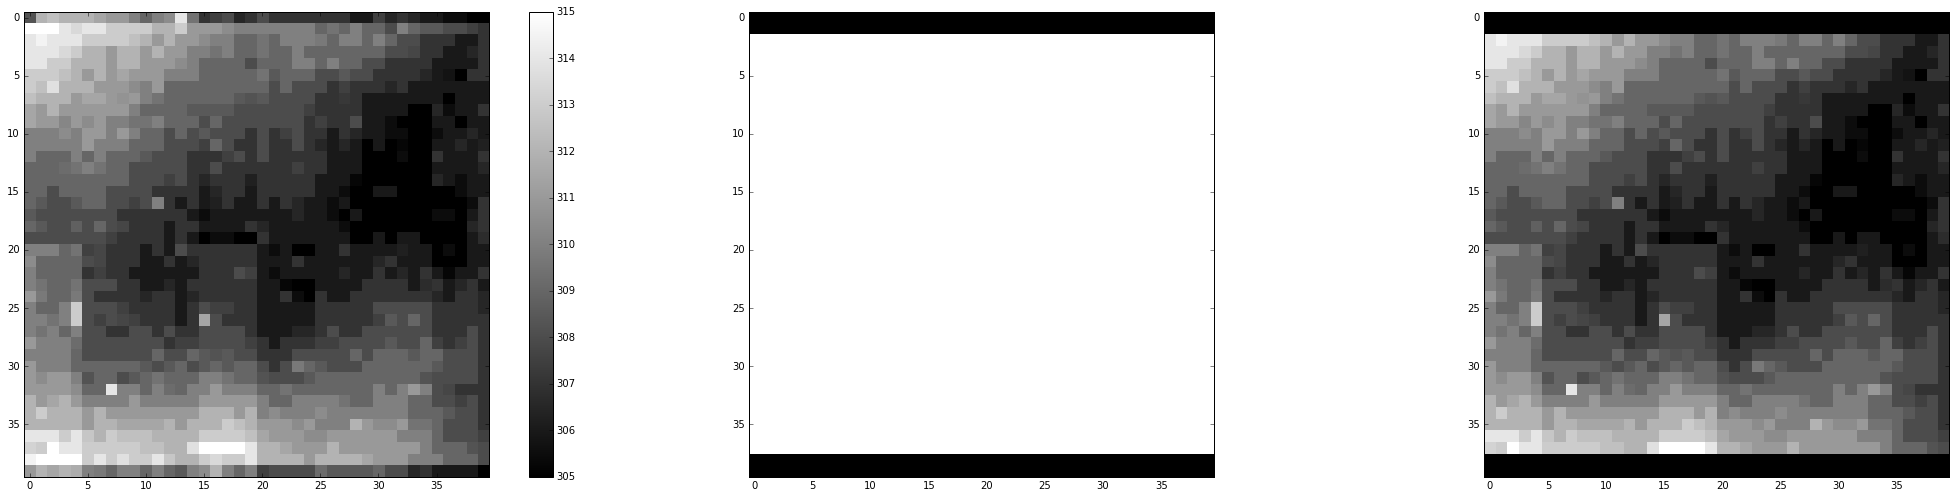

In [616]:
plt.figure(figsize=(32,7))

plt.subplot(131)
plt.imshow(img_coarse,interpolation='nearest',vmin=305,vmax=315,cmap='gray')
draw_region_lines(img_coarse.shape[0])
plt.colorbar()
plt.title('median binning')

plt.subplot(132)
offsets=[[0,0,0,0,0,0,0,0],[-1,0,0,-1,0,-1,-1,0]]
plt.imshow(apply_amp_region_offsets(img_coarse,offsets),interpolation='nearest',vmin=305,vmax=315,cmap='gray')
draw_region_lines(img_coarse.shape[0])
plt.colorbar()
plt.title('median binning with offsets = '+str(offsets))

plt.subplot(133)
plt.imshow(sub_median_from_each_amp_region(img_coarse),interpolation='nearest',vmin=-5,vmax=5,cmap='seismic')
draw_region_lines(img_coarse.shape[0])
plt.colorbar()
plt.title('subtract median from each amp region')

plt.tight_layout()

plt.figure(figsize=(32,7))

plt.subplot(131)
plt.imshow(img_coarser,interpolation='nearest',vmin=305,vmax=315,cmap='gray')
#draw_region_lines(img_coarse.shape[0])
plt.colorbar()

plt.subplot(132)
mask = np.ones(img_coarser.shape,dtype=bool)
mask[0:2,:] = 0
mask[-2:,:] = 0
plt.imshow(mask,interpolation='nearest',vmin=0,vmax=1,cmap='gray')
# draw_region_lines(img_coarse.shape[0])
# plt.colorbar()

plt.subplot(133)
plt.imshow(img_coarser_resampled*mask,interpolation='nearest',vmin=305,vmax=315,cmap='gray')
# draw_region_lines(img_coarse.shape[0])
# plt.colorbar()

plt.tight_layout()

In [758]:
# let's try a simultaneous fit for the region offsets and a 2D polynomial and floating point region offsets

#n = img_coarse.shape[0]
order = 4
num_poly_params = 2*order
print('for order = %d, num_poly_params = %d'%(order,num_poly_params))
def poly_and_offsets_mult(ind, *c):
    xi = 1.*(ind % n_coarser)/n_coarser-.5
    yi = 1.*(np.int32(ind/n_coarser))/n_coarser-.5

    regionoffsets = c[:16]
    xcoefs = c[16:16+order]
    ycoefs = c[16+order:]

    xpoly = 1 + np.sum([xcoefs[i]*(xi**(i+1)) for i in range(order)],axis=0)
    ypoly = 1 + np.sum([ycoefs[i]*(yi**(i+1)) for i in range(order)],axis=0)
    
    regiony = np.int32(2.*(yi+.5))
    regionx = np.int32(8.*(xi+.5))
    
    return xpoly*ypoly * np.array(regionoffsets)[regiony*8+regionx]

def poly_and_offsets_add(ind, *c):
    xi = 1.*(ind % n_coarser)/n_coarser-.5
    yi = 1.*(np.int32(ind/n_coarser))/n_coarser-.5

    regionoffsets = c[:16]
    xcoefs = c[16:16+order]
    ycoefs = c[16+order:]

    xpoly = 1 + np.sum([xcoefs[i]*(xi**(i+1)) for i in range(order)],axis=0)
    ypoly = 1 + np.sum([ycoefs[i]*(yi**(i+1)) for i in range(order)],axis=0)
    
    regiony = np.int32(2.*(yi+.5))
    regionx = np.int32(8.*(xi+.5))
    
    return xpoly*ypoly + np.array(regionoffsets)[regiony*8+regionx]

def poly(ind, *c):
    xi = 1.*(ind % n_coarser)/n_coarser-.5
    yi = 1.*(np.int32(ind/n_coarser))/n_coarser-.5

    xcoefs = c[1:1+order]
    ycoefs = c[1+order:]

    xpoly = 1 + np.sum([xcoefs[i]*(xi**(i+1)) for i in range(order)],axis=0)
    ypoly = 1 + np.sum([ycoefs[i]*(yi**(i+1)) for i in range(order)],axis=0)
    
    return xpoly*ypoly * c[0]    

for order = 4, num_poly_params = 8


In [760]:
#popt, pcov, infodict, errmsg, ier = curve_fit(poly_and_offsets, unmaskedinds, img_coarser[np.array(mask,dtype=bool)].flatten(), p0 = [306]*(16)+[-3,0,0,0,0,15,0,0],method='lm',maxfev=50000,full_output=True,xtol=1.e-6)
#popt, pcov = curve_fit(poly, unmaskedinds, img_coarser[np.array(mask,dtype=bool)].flatten(), p0 = [305,-2,0,0,0,0,10,0,20],method='trf')#,maxfev=50000)

In [764]:
unmaskedinds = np.where(mask.flatten())[0]
chisq_mult = lambda p0: np.sum((poly_and_offsets_mult(unmaskedinds,*p0)-img_coarser.flatten()[unmaskedinds])**2)

param_bounds_mult = [(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),\
                (300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),\
                (-.5,.5),(-.5,.5),(-.5,.5),(-.5,.5),(-.5,.5),(-.5,.5),(-.5,.5),(-.5,.5)]

result_mult = scipy.optimize.differential_evolution(chisq_mult, param_bounds_mult, polish=True)
print(result_mult['x'])

[  3.05564536e+02   3.05894247e+02   3.05769391e+02   3.05746305e+02
   3.06340437e+02   3.05687018e+02   3.04685045e+02   3.04730751e+02
   3.05350822e+02   3.04605913e+02   3.05227557e+02   3.06879950e+02
   3.06120496e+02   3.06701418e+02   3.06988966e+02   3.05628951e+02
  -1.53328175e-02   3.94186007e-02   8.99337281e-03  -6.82203728e-02
   1.84268238e-03   9.47283872e-02   2.72285259e-02  -8.68970145e-02]


In [766]:
chisq_add = lambda p0: np.sum((poly_and_offsets_add(unmaskedinds,*p0)-img_coarser.flatten()[unmaskedinds])**2)

param_bounds_add = [(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),\
                (300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),(300,310),\
                (-5,5),(-10,10),(-10,10),(-10,10),(-10,10),(-10,10),(-10,10),(-10,10)]
result_add = scipy.optimize.differential_evolution(chisq_add, param_bounds_add, polish=True)
print(result_add['x'])

[  3.06236051e+02   3.06462059e+02   3.06067361e+02   3.05728717e+02
   3.06054706e+02   3.05194398e+02   3.04131718e+02   3.04121385e+02
   3.06062322e+02   3.05282244e+02   3.05720152e+02   3.07135164e+02
   3.06067634e+02   3.06510870e+02   3.06639341e+02   3.05222415e+02
  -1.51234294e+00   6.20483073e+00  -4.52215700e-01  -1.00000000e+01
   1.74346214e-01   1.00000000e+01   3.96089174e+00   1.00000000e+01]


In [767]:
#p0test = [305,-1.e-2,5.e-3,-2.e-2,2.e-2,6.e-3,9.e-2,1.e-2,-6.e-2]
p0test = [308]*16+[0]*8
chisq(p0test)

6790.9375

In [768]:
chisq(list(result['x']))

776.84668087592888

In [769]:
# inds = np.arange(n_coarser**2)
# #model_flat = poly_and_offsets(inds,*p0test)
# p0test2 = [308,308,308,308,308,308,308,308]+[310,308,308,309,308,308,308,308] + [0,0,0,0,0,0,0,0]
# model_flat = poly_and_offsets(inds,*p0test2)
# model = np.reshape(model_flat,(n_coarser,n_coarser))

# plt.figure(figsize=(32,7))

# plt.subplot(131)
# plt.imshow(img_coarser*mask,interpolation='nearest',vmin=303,vmax=315,cmap='jet')
# plt.colorbar()

# plt.subplot(132)
# plt.imshow(model,interpolation='nearest',vmin=305,vmax=315,cmap='jet')
# plt.colorbar()

# plt.subplot(133)
# plt.imshow((img_coarser-model)*mask,interpolation='nearest',vmin=-5,vmax=5,cmap='seismic')
# plt.colorbar()

# plt.tight_layout()

In [774]:
matplotlib.rcParams.update({'font.size': 18})

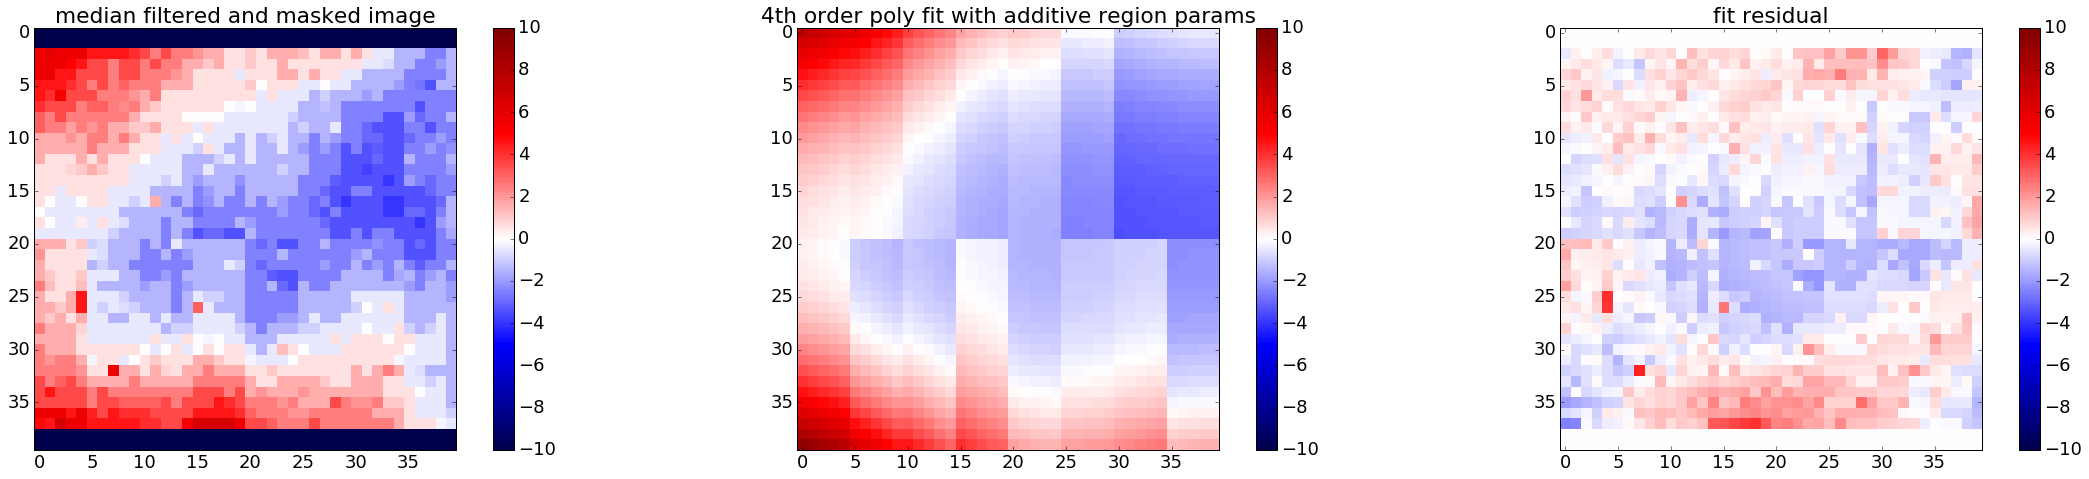

In [777]:
model2_flat = poly_and_offsets_add(inds,*list(result_add['x']))
model2 = np.reshape(model2_flat,(n_coarser,n_coarser))

plt.figure(figsize=(32,7))

v1 = 303
v2 = 315

plt.subplot(131)
plt.imshow(img_coarser*mask-img_coarser.mean(),interpolation='nearest',vmin=-10,vmax=10,cmap='seismic')
plt.title('median filtered and masked image')
plt.colorbar()

plt.subplot(132)
plt.imshow(model2-model2.mean(),interpolation='nearest',vmin=-10,vmax=10,cmap='seismic')
plt.title('4th order poly fit with additive region params')
plt.colorbar()

plt.subplot(133)
plt.imshow((img_coarser-model2)*mask,interpolation='nearest',vmin=-10,vmax=10,cmap='seismic')
plt.title('fit residual')
plt.colorbar()

plt.tight_layout()
plt.savefig('additive_params.png',bbox_inches='tight')

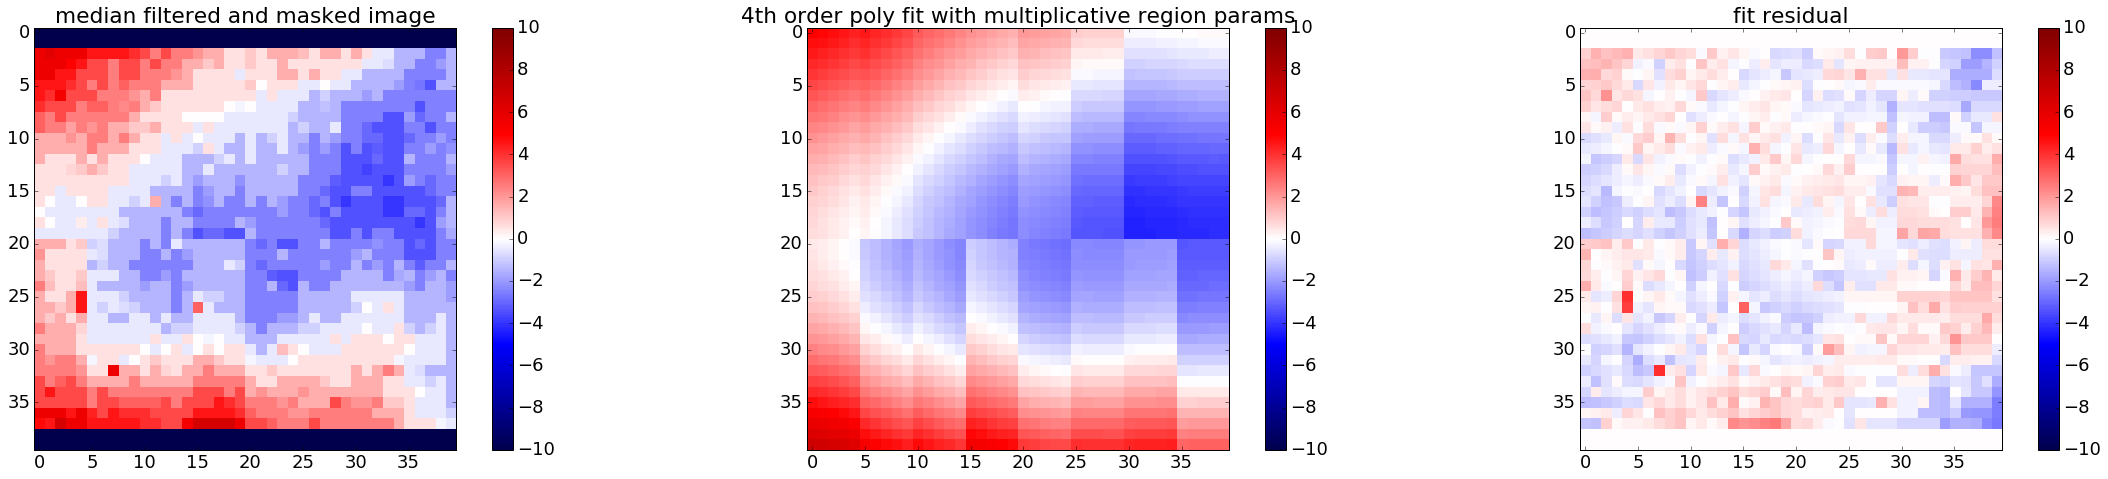

In [778]:
model2_flat = poly_and_offsets_mult(inds,*list(result_mult['x']))
model2 = np.reshape(model2_flat,(n_coarser,n_coarser))

plt.figure(figsize=(32,7))

v1 = 303
v2 = 315

plt.subplot(131)
plt.imshow(img_coarser*mask-img_coarser.mean(),interpolation='nearest',vmin=-10,vmax=10,cmap='seismic')
plt.title('median filtered and masked image')
plt.colorbar()

plt.subplot(132)
plt.imshow(model2-model2.mean(),interpolation='nearest',vmin=-10,vmax=10,cmap='seismic')
plt.title('4th order poly fit with multiplicative region params')
plt.colorbar()

plt.subplot(133)
plt.imshow((img_coarser-model2)*mask,interpolation='nearest',vmin=-10,vmax=10,cmap='seismic')
plt.title('fit residual')
plt.colorbar()

plt.tight_layout()
plt.savefig('multiplicative_params.png',bbox_inches='tight')

In [772]:
# plt.figure(figsize=(25,8))
# plt.plot(img_coarser.flatten()[unmaskedinds],'b')
# plt.plot(poly_and_offsets(unmaskedinds,*p0test2),'r')
# plt.plot(poly_and_offsets(unmaskedinds,*list(result['x'])),'g')